# Backward selection

In [1]:
HOUSING_PATH = "data/housing.csv"

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

In [3]:
housing = pd.read_csv(HOUSING_PATH)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [5]:
#Разбиваем сет 
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class PipelineFriendlyLabelBinarizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None,**fit_params):
        return self
    def transform(self, X):
        return LabelBinarizer().fit(X).transform(X)

In [15]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer

num_attribs = strat_train_set.columns.drop(["ocean_proximity", "median_house_value"])
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', PipelineFriendlyLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

/Users/k.gusev/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
X_train = strat_train_set.drop("median_house_value", axis=1)
y_train = strat_train_set["median_house_value"].copy()

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [16]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

66911.98070857547

## Выбор фич

In [74]:
columns = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms', 
    'total_bedrooms', 'population', 'households', 'median_income',
    'rooms_per_household', 'population_per_household', 'bedrooms_per_room',
    'lt_1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN', 'median_house_value'
]

train_df = pd.DataFrame(np.c_[X_train_prepared, y_train], columns=columns)
test_df = pd.DataFrame(np.c_[X_test_prepared, y_test], columns=columns)

In [41]:
train_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,lt_1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN,median_house_value
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-4.272678e-15,2.275755e-15,-2.700521e-16,8.606884e-17,1.181562e-16,-4.347735e-17,9.614940e-18,-2.225960e-16,7.258944e-17,-1.592516e-17,-5.100205e-17,0.440649,0.318738,0.000121,0.111858,0.128634,206990.920724
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,0.496480,0.466001,0.011005,0.315201,0.334804,115703.014830
min,-2.384937e+00,-1.449760e+00,-2.199168e+00,-1.223689e+00,-1.294944e+00,-1.269921e+00,-1.317668e+00,-1.772116e+00,-1.650273e+00,-2.075303e-01,-2.704542e+00,0.000000,0.000000,0.000000,0.000000,0.000000,14999.000000
25%,-1.111083e+00,-7.949406e-01,-8.472092e-01,-5.516890e-01,-5.793145e-01,-5.698825e-01,-5.803963e-01,-6.870806e-01,-3.822514e-01,-5.741738e-02,-5.914834e-01,0.000000,0.000000,0.000000,0.000000,0.000000,119800.000000
50%,5.324379e-01,-6.452675e-01,2.758786e-02,-2.353301e-01,-2.458409e-01,-2.292746e-01,-2.370459e-01,-1.756999e-01,-7.966522e-02,-2.406537e-02,-1.628895e-01,0.000000,0.000000,0.000000,0.000000,0.000000,179500.000000
75%,7.822131e-01,9.730728e-01,6.638039e-01,2.423650e-01,2.604547e-01,2.684162e-01,2.793106e-01,4.561338e-01,2.358755e-01,1.596812e-02,4.044268e-01,1.000000,1.000000,0.000000,0.000000,0.000000,263900.000000
max,2.630550e+00,2.951564e+00,1.856709e+00,1.716114e+01,1.381603e+01,3.071047e+01,1.293803e+01,5.839969e+00,5.225419e+01,1.070603e+02,3.975916e+01,1.000000,1.000000,1.000000,1.000000,1.000000,500001.000000


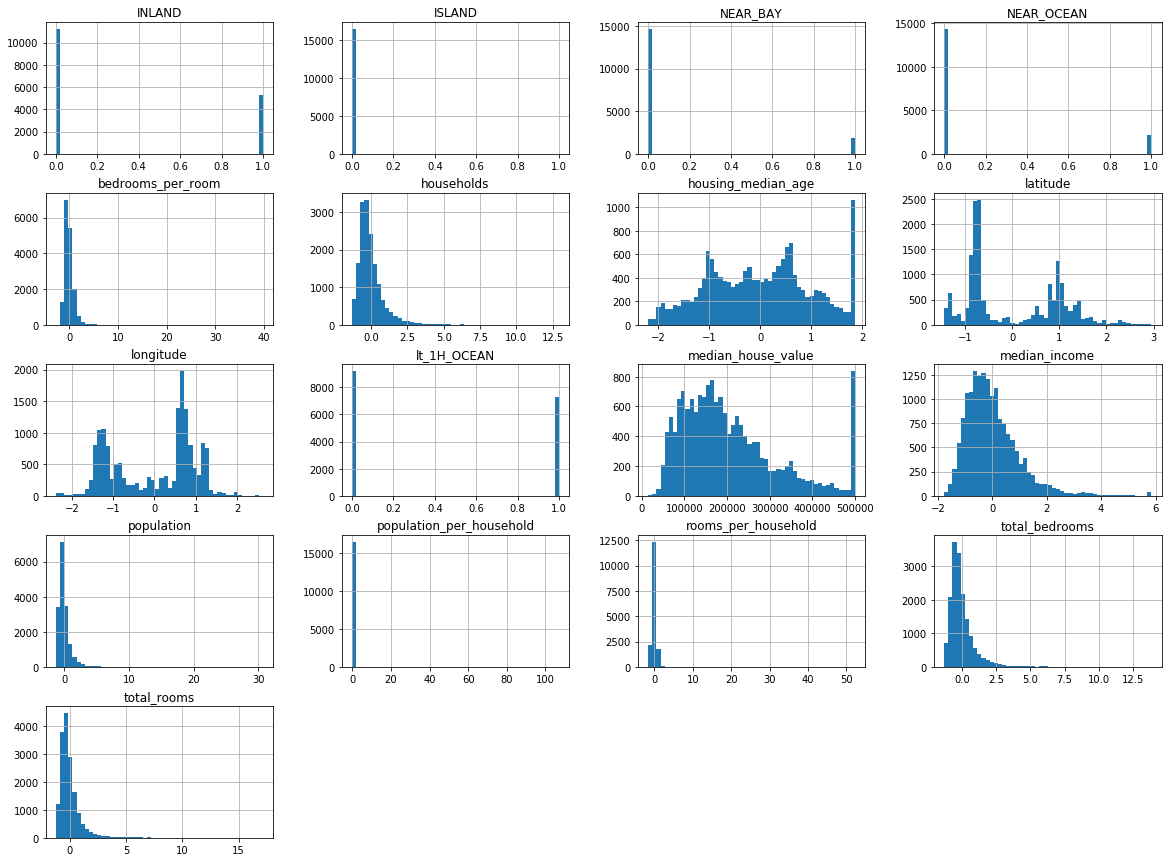

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
train_df.hist(bins=50, figsize=(20,15))
plt.show()

In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### Итерация 0

In [46]:
_iteration_cols = train_df.columns.drop('median_house_value')

In [47]:
def get_formula(_cols):
    return 'median_house_value ~ ' + " + ".join(_cols)

In [48]:
get_formula(_iteration_cols)

'median_house_value ~ longitude + latitude + housing_median_age + total_rooms + total_bedrooms + population + households + median_income + rooms_per_household + population_per_household + bedrooms_per_room + lt_1H_OCEAN + INLAND + ISLAND + NEAR_BAY + NEAR_OCEAN'

In [75]:
lm = smf.ols(get_formula(_iteration_cols), test_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 67679.7887851451
R^2: 0.6485052559515514


In [50]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.974e+05,8110.772,24.342,0.000,1.82e+05,2.13e+05
longitude,-5.565e+04,2292.900,-24.271,0.000,-6.01e+04,-5.12e+04
latitude,-5.672e+04,2415.407,-23.481,0.000,-6.15e+04,-5.2e+04
housing_median_age,1.373e+04,616.482,22.276,0.000,1.25e+04,1.49e+04
total_rooms,-1933.1277,2190.578,-0.882,0.378,-6226.896,2360.640
total_bedrooms,7330.0406,3199.094,2.291,0.022,1059.471,1.36e+04
population,-4.571e+04,1374.652,-33.251,0.000,-4.84e+04,-4.3e+04
households,4.546e+04,3145.090,14.453,0.000,3.93e+04,5.16e+04
median_income,7.471e+04,755.337,98.915,0.000,7.32e+04,7.62e+04
rooms_per_household,6605.1280,675.776,9.774,0.000,5280.535,7929.721


### Итерация 2

In [51]:
# выкинем total_rooms так как у него наибольшоее p-value
_iteration_cols = _iteration_cols.drop('total_rooms')

In [52]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 68629.81811508129
R^2: 0.6481458743687454


In [ ]:
RMSE: 68628.19819848923
R^2: 0.6481624842804428

In [54]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.974e+05,8110.541,24.336,0.000,1.81e+05,2.13e+05
longitude,-5.571e+04,2291.741,-24.311,0.000,-6.02e+04,-5.12e+04
latitude,-5.68e+04,2413.529,-23.534,0.000,-6.15e+04,-5.21e+04
housing_median_age,1.375e+04,616.086,22.322,0.000,1.25e+04,1.5e+04
total_bedrooms,5940.7106,2784.869,2.133,0.033,482.066,1.14e+04
population,-4.604e+04,1323.095,-34.795,0.000,-4.86e+04,-4.34e+04
households,4.532e+04,3141.172,14.427,0.000,3.92e+04,5.15e+04
median_income,7.45e+04,714.286,104.297,0.000,7.31e+04,7.59e+04
rooms_per_household,6519.6056,668.786,9.748,0.000,5208.713,7830.498
population_per_household,1076.6370,551.803,1.951,0.051,-4.956,2158.230


### Итерация 3

In [60]:
# выкиним NEAR_OCEAN так как у него наибольшоее p-value
_iteration_cols = _iteration_cols.drop('INLAND')

KeyError: "['INLAND'] not found in axis"

In [61]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 69173.97650925133
R^2: 0.6425441277398208


In [ ]:
RMSE: 68628.19819848923
R^2: 0.6481624842804428

In [62]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.994e+05,899.302,221.762,0.000,1.98e+05,2.01e+05
longitude,-7.924e+04,1787.125,-44.342,0.000,-8.27e+04,-7.57e+04
latitude,-8.32e+04,1794.813,-46.357,0.000,-8.67e+04,-7.97e+04
housing_median_age,1.417e+04,620.416,22.834,0.000,1.3e+04,1.54e+04
total_bedrooms,6232.2154,2806.807,2.220,0.026,730.572,1.17e+04
population,-4.762e+04,1329.895,-35.809,0.000,-5.02e+04,-4.5e+04
households,4.65e+04,3165.128,14.691,0.000,4.03e+04,5.27e+04
median_income,7.504e+04,719.124,104.355,0.000,7.36e+04,7.65e+04
rooms_per_household,7115.4432,673.049,10.572,0.000,5796.195,8434.692
population_per_household,1172.9455,556.129,2.109,0.035,82.873,2263.018


### Итерация 4

In [63]:
# выкиним lt_1H_OCEAN так как у него наибольшоее p-value
_iteration_cols = _iteration_cols.drop('population_per_household')

In [64]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 69183.30168548762
R^2: 0.6424477457229576


In [65]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.995e+05,899.282,221.801,0.000,1.98e+05,2.01e+05
longitude,-7.92e+04,1787.192,-44.316,0.000,-8.27e+04,-7.57e+04
latitude,-8.312e+04,1794.569,-46.317,0.000,-8.66e+04,-7.96e+04
housing_median_age,1.42e+04,620.249,22.898,0.000,1.3e+04,1.54e+04
total_bedrooms,6359.8854,2806.447,2.266,0.023,858.946,1.19e+04
population,-4.694e+04,1290.007,-36.387,0.000,-4.95e+04,-4.44e+04
households,4.574e+04,3144.649,14.544,0.000,3.96e+04,5.19e+04
median_income,7.513e+04,717.950,104.650,0.000,7.37e+04,7.65e+04
rooms_per_household,7081.6700,672.929,10.524,0.000,5762.657,8400.683
bedrooms_per_room,1.056e+04,707.638,14.921,0.000,9171.861,1.19e+04


### Итерация 5

In [66]:
# выкиним population_per_household так как у него наибольшоее p-value
_iteration_cols = _iteration_cols.drop('total_bedrooms')

In [67]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 69194.06794167304
R^2: 0.6423364530091498


In [68]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.995e+05,899.108,221.901,0.000,1.98e+05,2.01e+05
longitude,-7.88e+04,1778.527,-44.305,0.000,-8.23e+04,-7.53e+04
latitude,-8.28e+04,1789.371,-46.275,0.000,-8.63e+04,-7.93e+04
housing_median_age,1.411e+04,618.911,22.794,0.000,1.29e+04,1.53e+04
population,-4.726e+04,1282.341,-36.855,0.000,-4.98e+04,-4.47e+04
households,5.224e+04,1288.009,40.556,0.000,4.97e+04,5.48e+04
median_income,7.508e+04,717.602,104.622,0.000,7.37e+04,7.65e+04
rooms_per_household,7733.7482,608.382,12.712,0.000,6541.254,8926.243
bedrooms_per_room,1.101e+04,679.306,16.206,0.000,9677.273,1.23e+04
lt_1H_OCEAN,1.449e+04,1356.116,10.688,0.000,1.18e+04,1.72e+04


### Итерация 6

In [69]:
# выкиним total_bedrooms так как у него наибольшоее p-value
_iteration_cols = _iteration_cols.drop('ISLAND')

In [70]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 69209.6401450976
R^2: 0.6421754497208492


In [ ]:
RMSE: 68628.19819848923
R^2: 0.6481624842804428

In [71]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.996e+05,898.986,222.002,0.000,1.98e+05,2.01e+05
longitude,-7.889e+04,1778.531,-44.358,0.000,-8.24e+04,-7.54e+04
latitude,-8.292e+04,1789.216,-46.344,0.000,-8.64e+04,-7.94e+04
housing_median_age,1.412e+04,619.018,22.809,0.000,1.29e+04,1.53e+04
population,-4.727e+04,1282.586,-36.856,0.000,-4.98e+04,-4.48e+04
households,5.224e+04,1288.259,40.550,0.000,4.97e+04,5.48e+04
median_income,7.507e+04,717.737,104.593,0.000,7.37e+04,7.65e+04
rooms_per_household,7742.1328,608.493,12.723,0.000,6549.421,8934.844
bedrooms_per_room,1.102e+04,679.424,16.221,0.000,9689.209,1.24e+04
lt_1H_OCEAN,1.441e+04,1356.017,10.625,0.000,1.18e+04,1.71e+04


### Итерация 7

In [95]:
# выкиним NEAR_BAY так как у него наибольшоее p-value
_iteration_cols = _iteration_cols.drop('NEAR_BAY')

In [96]:
lm = smf.ols(get_formula(_iteration_cols), train_df).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 68669.71573888215
R^2: 0.6477366579544396


In [97]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.187e+05,809.450,270.133,0.000,2.17e+05,2.2e+05
longitude,-5.553e+04,2212.506,-25.098,0.000,-5.99e+04,-5.12e+04
latitude,-5.744e+04,2357.711,-24.361,0.000,-6.21e+04,-5.28e+04
housing_median_age,1.336e+04,603.727,22.131,0.000,1.22e+04,1.45e+04
population,-4.574e+04,1269.687,-36.026,0.000,-4.82e+04,-4.33e+04
households,5.071e+04,1274.310,39.791,0.000,4.82e+04,5.32e+04
median_income,7.439e+04,710.130,104.751,0.000,7.3e+04,7.58e+04
rooms_per_household,7150.3119,603.844,11.841,0.000,5966.713,8333.910
bedrooms_per_room,1.001e+04,676.542,14.799,0.000,8685.847,1.13e+04
INLAND,-3.666e+04,1906.996,-19.223,0.000,-4.04e+04,-3.29e+04


## Посмотрим на результат

In [72]:
sub_X_train_prepared = train_df[_iteration_cols].values
sub_X_test_prepared = test_df[_iteration_cols].values

In [99]:
68634

In [73]:
lin_reg = LinearRegression().fit(sub_X_train_prepared, y_train)
y_pred = lin_reg.predict(sub_X_test_prepared)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
rmse

67774.88950355176

In [ ]:
RMSE: 67679.7887851451
R^2: 0.6485052559515514